In [21]:
import pandas as pd
import numpy as np
mental_health_df = pd.read_csv('university_mental_health_iot_dataset.csv')
mental_health_df.shape

(1000, 12)

**The dataset contains 1000 observations through the pandas 'shape' attribute.**

## Target Research Questions

**1. To what extent do environmental factors (temperature, humidity, air quality, noise, lighting, crowd density) predict student stress levels, and which factors have the strongest relationship?**

EDA: 
1. What is the correlation between each environmental factor and student stress levels?
2. Which environmental factor has the strongest relationship with stress levels?
3. Are there any non-linear relationships between environmental factors and stress?
4. Do certain locations consistently show higher stress levels regardless of environmental conditions?

**2. How does sleep duration interact with environmental conditions to influence student mood scores, and can specific thresholds of sleep be identified that buffer against negative environmental effects?**

EDA: 
1. How does mood score vary with sleep hours among students exposed to high vs. low environmental stressors?
2. Is there a threshold of sleep duration that appears to protect against negative environmental effects?
3. Which environmental factor shows the strongest interaction with sleep duration in predicting mood?
4. Does the relationship between sleep and mood differ across different campus locations?

**3. What combination of environmental conditions differentiates locations with higher rates of mental health risk (status 1-2) from those with predominantly normal status (0), and can these patterns inform university space design?**

EDA: 
1. What are the average values of environmental variables in locations/times where mental health status is at risk (1) vs. normal (0)?
2. Which locations have the highest proportion of at-risk mental health statuses?
3. Are there specific combinations of environmental factors that are consistently associated with at-risk mental health status?
4. Do temporal patterns exist in the relationship between environmental conditions and mental health status?

## Data Preprocessing
Our data preprocessing approach ensures that the dataset is accurate, consistent, and fully prepared for analysis. We started by inspecting the data for missing values and duplicates, confirming that the dataset is complete and unique. Next, we standardized numerical precision across relevant columns, rounding values to appropriate decimal places to enhance consistency and interpretability. We also converted key columns—such as timestamps and categorical variables—to their correct data types, enabling more effective time-based and group analyses. Outlier detection was performed using summary statistics, allowing us to identify any unusual or potentially problematic values. Each transformation was carefully documented and verified, resulting in a clean and reliable dataset that provides a solid foundation for meaningful exploratory analysis and modeling.

It is noticed that the decimal inconsistency in the specified columns: **temperature_celsius**, **humidity_percent**, **noise_level_db**, and **sleep_hours** constitutes a data integrity issue affecting numerical precision and standardization. Through data cleaning, specifically rounding to uniform decimal digits the dataset’s quality, reliability, and analytical value are significantly enhanced.

The function **'min_decimal_places'** is used to identify the lowest number of decimal digits present within each specified column. This lowest decimal digit is then applied uniformly to all values in the column, ensuring consistent decimal formatting. Such standardization improves data integrity and facilitates accurate analysis.

In [22]:
def min_decimal_places(series):
    series = series.dropna()
    decimals = series.astype(str).apply(
        lambda x: len(x.split('.')[-1]) if '.' in x else 0
    )
    return decimals.min()

The function **'implement_min_decimal'** is used to implement the data cleaning basing on the returned number of decimal digits from 'min_decimal_places' function and then rounded off if the min_decimal_places value is < than the data's decimal value

In [23]:
def implement_min_decimal(column):
    cleaned_column = column.round(min_decimal_places(column))
    return cleaned_column

**Implementation of the funtions to the columns**

In [24]:
# List of columns to clean (excluding mood_score and mental_health_status if not needed)
columns_to_clean = [
    'temperature_celsius', 'humidity_percent', 'noise_level_db', 'sleep_hours'
]

# Apply implement_min_decimal to each column in the list
for col in columns_to_clean:
    mental_health_df[col] = implement_min_decimal(mental_health_df[col])

# Verification for cleaned columns
print(mental_health_df[columns_to_clean].head(10))

   temperature_celsius  humidity_percent  noise_level_db  sleep_hours
0            24.328184         62.987529       54.429034          7.2
1            26.177300         52.482089       62.336451          5.0
2            25.443028         55.736424       51.967691          5.0
3            24.671652         71.484457       54.658851          8.2
4            21.628577         61.132704       60.623440          6.6
5            25.414405         45.617220       51.121999          6.5
6            29.646073         69.192289       52.022026          7.6
7            28.036260         53.318559       43.232965          9.7
8            28.779560         78.732978       54.850632          5.8
9            22.466353         70.800481       51.651515          7.6


**Lighting Lux Standardization**

To ensure consistency and interpretability, we round the **lighting_lux** values to the nearest integer. Lux, as a unit of light intensity, is almost always measured and reported as a whole number in both sensor outputs and practical applications. This step removes insignificant decimal places, making the data cleaner and easier to analyze without sacrificing any meaningful information.

In [25]:
mental_health_df['lighting_lux'] = mental_health_df['lighting_lux'].round(0).astype(int)

**Categorical Variable Conversion**

We convert the **location_id** and **mental_health_status** columns to categorical data types. This not only optimizes memory usage but also clarifies the nature of these variables as discrete categories rather than continuous numbers. Properly encoding categorical variables is essential for accurate analysis and modeling, especially when performing group-based operations or preparing data for machine learning algorithms.



In [26]:
mental_health_df['location_id'] = mental_health_df['location_id'].astype('category')
mental_health_df['mental_health_status'] = mental_health_df['mental_health_status'].astype('category')

**Timestamp Parsing**

We convert the **timestamp** column from string format to a datetime object. This transformation enables us to perform time-based analyses, such as identifying trends over specific periods, aggregating data by hour or day, and visualizing temporal patterns. Accurate datetime formatting is foundational for any analysis involving time series or temporal relationships.

In [27]:
mental_health_df['timestamp'] = pd.to_datetime(mental_health_df['timestamp'])

**Missing Values and Duplicate Checks**

Before further processing, we check for missing values and duplicate rows in the dataset. Addressing these issues at the outset prevents potential biases and errors in our analysis. If any are found, we can decide whether to impute, remove, or otherwise handle them based on the context and extent of the issue.

In [28]:
print(mental_health_df.isna().sum())
print(mental_health_df.duplicated().sum())

timestamp               0
location_id             0
temperature_celsius     0
humidity_percent        0
air_quality_index       0
noise_level_db          0
lighting_lux            0
crowd_density           0
stress_level            0
sleep_hours             0
mood_score              0
mental_health_status    0
dtype: int64
0


**Result:** 
 
The output above shows that there are **no missing values** and **no duplicate rows** in the dataset. This confirms that the data is complete and unique, allowing us to proceed confidently with further analysis.

**Outlier Detection**

We examine summary statistics and visualizations for each numerical column to identify potential outliers or anomalous values. Detecting and addressing outliers is crucial, as they can disproportionately influence statistical analyses and model performance. Depending on the findings, we may choose to investigate, correct, or exclude these values from further analysis.

In [29]:
print(mental_health_df.describe())

                 timestamp  temperature_celsius  humidity_percent  \
count                 1000          1000.000000       1000.000000   
mean   2024-05-06 12:52:30            24.208457         60.189320   
min    2024-05-01 08:00:00            15.235949         29.804878   
25%    2024-05-03 22:26:15            22.183079         53.726462   
50%    2024-05-06 12:52:30            24.168562         60.048989   
75%    2024-05-09 03:18:45            26.125555         66.726456   
max    2024-05-11 17:45:00            33.579323         91.377485   
std                    NaN             3.012801          9.747296   

       air_quality_index  noise_level_db  lighting_lux  crowd_density  \
count        1000.000000     1000.000000    1000.00000    1000.000000   
mean           85.446000       54.722387     301.49300      31.736000   
min            20.000000       24.540712     155.00000       5.000000   
25%            51.000000       47.853538     267.00000      18.000000   
50%          

**Outlier Handling**

After identifying potential outliers using summary statistics, we proceed to handle them to ensure they do not unduly influence our analysis. We use the Interquartile Range (IQR) method to detect outliers for each numerical column. Values lying below Q1 - 1.5*IQR or above Q3 + 1.5*IQR are considered outliers. We will flag these outliers and, for this analysis, remove them to maintain data integrity.

In [30]:
# List of numerical columns to check for outliers
num_cols = [
    'temperature_celsius', 'humidity_percent', 'air_quality_index',
    'noise_level_db', 'lighting_lux', 'crowd_density',
    'stress_level', 'sleep_hours', 'mood_score'
]

# Function to remove outliers using IQR
def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        before = df.shape[0]
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
        after = df.shape[0]
        print(f"{col}: Removed {before - after} outliers")
    return df

# Remove outliers
mental_health_df_clean = remove_outliers_iqr(mental_health_df, num_cols)

# Show the new shape of the cleaned dataset
print("New dataset shape after outlier removal:", mental_health_df_clean.shape)

temperature_celsius: Removed 8 outliers
humidity_percent: Removed 11 outliers
air_quality_index: Removed 0 outliers
noise_level_db: Removed 7 outliers
lighting_lux: Removed 7 outliers
crowd_density: Removed 0 outliers
stress_level: Removed 1 outliers
sleep_hours: Removed 7 outliers
mood_score: Removed 3 outliers
New dataset shape after outlier removal: (956, 12)


**Result**  
Outliers have been removed from the dataset using the IQR method for each numerical column. The updated dataset is now less likely to be influenced by extreme values, ensuring more robust and reliable analysis in subsequent steps.

1. To what extent do environmental factors (temperature, humidity, air quality, noise, lighting, crowd density) predict student stress levels, and which factors have the strongest relationship?

EDA:

1.1 What is the correlation between each environmental factor and student stress levels?

In [31]:
mental_health_df_clean.head()

,timestamp,location_id,temperature_celsius,humidity_percent,air_quality_index,noise_level_db,lighting_lux,crowd_density,stress_level,sleep_hours,mood_score,mental_health_status
0,2024-05-01 08:00:00,104,24.328184,62.987529,67,54.429034,323,45,23,7.2,2.3,0
1,2024-05-01 08:15:00,105,26.177300,52.482089,77,62.336451,412,17,54,5.0,1.7,1
2,2024-05-01 08:30:00,103,25.443028,55.736424,120,51.967691,387,35,39,5.0,2.9,0
3,2024-05-01 08:45:00,105,24.671652,71.484457,131,54.658851,339,25,39,8.2,0.0,0
4,2024-05-01 09:00:00,105,21.628577,61.132704,81,60.623440,341,36,18,6.6,3.0,0


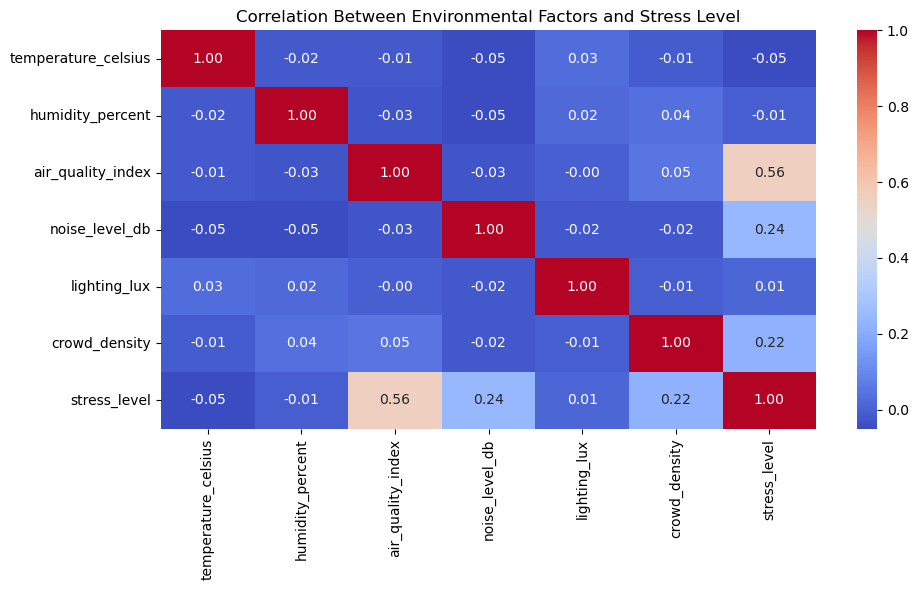

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select relevant columns
env_features = [
    "temperature_celsius", "humidity_percent", "air_quality_index",
    "noise_level_db", "lighting_lux", "crowd_density", "stress_level"
]

# Correlation matrix
corr_matrix = mental_health_df_clean[env_features].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Environmental Factors and Stress Level")
plt.tight_layout()
plt.show()

///Description on the Observed Plot
 - Air quality seems to have the highest correlation

1.2 Are there any non-linear relationships between environmental factors and stress?

RuntimeError: `lowess=True` requires statsmodels, an optional dependency, to be installed.

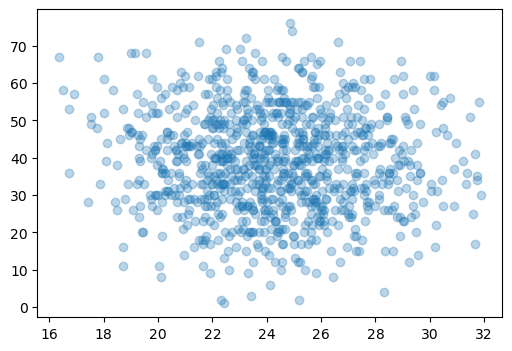

In [33]:
env_vars = ["temperature_celsius", "humidity_percent", "air_quality_index", 
            "noise_level_db", "lighting_lux", "crowd_density"]

# Plot non-linear relationships with LOWESS (locally weighted smoothing)
for var in env_vars:
    plt.figure(figsize=(6, 4))
    sns.regplot(data=mental_health_df_clean, x=var, y="stress_level", lowess=True, scatter_kws={'alpha':0.3})
    plt.title(f"Stress Level vs {var.replace('_', ' ').title()} (LOWESS Curve)")
    plt.tight_layout()
    plt.show()

//Describe Results

1.3 Do certain locations consistently show higher stress levels regardless of environmental conditions?

In [ ]:
# Average stress level per location
avg_stress_per_location = mental_health_df.groupby("location_id")["stress_level"].mean().sort_values(ascending=False)

# Plot
avg_stress_per_location.plot(kind="bar", figsize=(10, 4), title="Average Stress Level per Location")
plt.ylabel("Avg Stress Level")
plt.xlabel("Location ID")
plt.tight_layout()
plt.show()

//Describe Results